# Семантическая сегментация на PyTorch
## Задачи
1) Прочитать статью BiSeNet https://arxiv.org/abs/1808.00897

2) Загрузить датасет https://drive.google.com/open?id=1MOTVekem9o6PyEaXnuzYuzq8HdzNpHnC

3) Реализовать архитектуру BiSeNet, заполнив пропуски в шаблоне ниже, и применить её для задачи сегментации эллипсов

4) Реализовать и подсчитать метрику качества (любую из нижепреведенных) по валидационному датасету, построить графики в TensorBoard

* пиксельная точность (pixel accuracy): $\sum_{c=1}^{N_c}{n_{cc}}~/~\sum_{c=1}^{N_c}{n_c}$;

* средняя точность (mean accuracy): $\frac{1}{N_c}\sum_{c=1}^{N_c}{(n_{cc}~/~n_c)}$;

* средний коэффициент Жаккара (mean intersection over union): $\frac{1}{N_c}\sum_{c=1}^{N_c}{[n_{cc}~/~(n_c+\sum_{c'}^{N_c}{n_{c'c}}-n_{cc})]}$;

где: 
* $N_c$ - число классов в эталонной разметке для рассматриваемого изображения;
* $n_{ij}$ - число пикселей класса $i$, с предсказанным классом $j$ на рассматриваемом изображении;
* $n_c=\sum_{j}^{N_c}{n_{cj}}$ - общее число пикселей с эталонным классом $c$ на рассматриваемом изображении.

5) Визуализировать результат работы сети на нескольких изображениях


In [4]:
from tqdm import tqdm
import numpy as np
from skimage.io import imread
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

import os
from glob import glob

%matplotlib inline

### Датасеты для обучения и тестирования

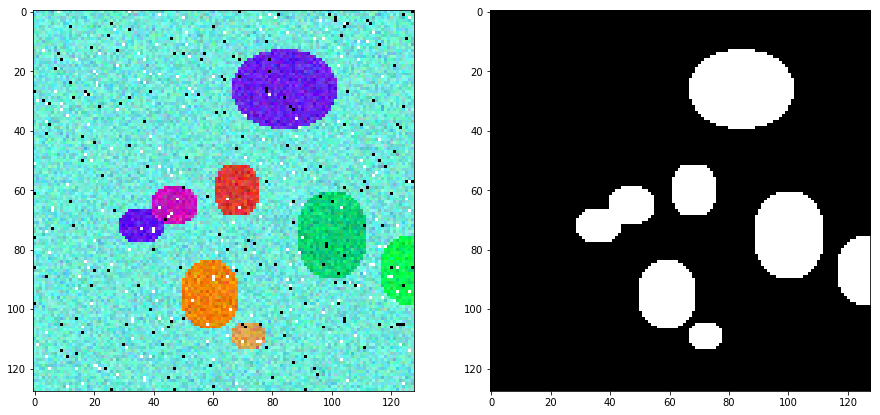

In [5]:
class Ellipses(Dataset):
    def __init__(self, path):
        self.transform = torchvision.transforms.ToTensor()
        self.imgs = [imread(x) for x in glob(os.path.join(path,'imgs/*.png'))]
        self.masks = [imread(x)[:, :, np.newaxis] for x in glob(os.path.join(path,'masks/*.png'))]
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img = self.imgs[idx]
        mask = self.masks[idx]
        return self.transform(img), self.transform(mask)
    
# Datasets
data_train = Ellipses("ellipse_database/train/")
data_eval = Ellipses("ellipse_database/eval/")

# Example images
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.imshow(data_train[0][0].cpu().numpy().transpose(1, 2, 0))
plt.subplot(1, 2, 2)
_ = plt.imshow(data_train[0][1][0, :, :].cpu().numpy(), cmap='gray')

https://towardsdatascience.com/bisenet-for-real-time-segmentation-part-iii-f2b40ba4e177

### Описание модели BiSeNet

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


class ConvBnRelu(nn.Module):
    def __init__(self, in_planes, out_planes, ksize, stride, pad, dilation=1,
                 groups=1, has_bn=True, norm_layer=nn.BatchNorm2d, bn_eps=1e-5,
                 has_relu=True, inplace=True, has_bias=False):
        super(ConvBnRelu, self).__init__()
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=ksize,
                              stride=stride, padding=pad,
                              dilation=dilation, groups=groups, bias=has_bias)
        self.has_bn = has_bn
        if self.has_bn:
            self.bn = norm_layer(out_planes, eps=bn_eps)
        self.has_relu = has_relu
        if self.has_relu:
            self.relu = nn.ReLU(inplace=inplace)

    def forward(self, x):
        x = self.conv(x)
        if self.has_bn:
            x = self.bn(x)
        if self.has_relu:
            x = self.relu(x)

        return x


# For BiSeNet
class AttentionRefinement(nn.Module):
    def __init__(self, in_planes, out_planes,
                 norm_layer=nn.BatchNorm2d):
        super(AttentionRefinement, self).__init__()
        self.conv_3x3 = ConvBnRelu(in_planes, out_planes, 3, 1, 1,
                                   has_bn=True, norm_layer=norm_layer,
                                   has_relu=True, has_bias=False)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(out_planes, out_planes, 1, 1, 0,
                       has_bn=True, norm_layer=norm_layer,
                       has_relu=False, has_bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        fm = self.conv_3x3(x)
        fm_se = self.channel_attention(fm)
        fm = fm * fm_se

        return fm


class FeatureFusion(nn.Module):
    def __init__(self, in_planes, out_planes,
                 reduction=1, norm_layer=nn.BatchNorm2d):
        super(FeatureFusion, self).__init__()
        self.conv_1x1 = ConvBnRelu(in_planes, out_planes, 1, 1, 0,
                                   has_bn=True, norm_layer=norm_layer,
                                   has_relu=True, has_bias=False)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(out_planes, out_planes // reduction, 1, 1, 0,
                       has_bn=False, norm_layer=norm_layer,
                       has_relu=True, has_bias=False),
            ConvBnRelu(out_planes // reduction, out_planes, 1, 1, 0,
                       has_bn=False, norm_layer=norm_layer,
                       has_relu=False, has_bias=False),
            nn.Sigmoid()
        )

    def forward(self, x1, x2):
        fm = torch.cat([x1, x2], dim=1)
        fm = self.conv_1x1(fm)
        fm_se = self.channel_attention(fm)
        output = fm + fm * fm_se
       
        return output


class ResNetEncoder(nn.Module):
    """ Encoder based on ResNet model.
    
    Attributes:
        n_channels_x16 (int): number of channels in feature map after 3rd block.
        n_channels_x32 (int): number of channels in feature map after 4th block.
    """
    def __init__(self, _resnet):
        """ Init.
    
            Args:
                _resnet: resnet model from torchvision.models.
        """
        super().__init__()
        if _resnet == None:
            _resnet = models.resnet50(pretrained=True)
        self._resnet = _resnet(pretrained=True)
        self.conv1 = self._resnet.conv1
        self.bn1 = self._resnet.bn1
        self.relu = self._resnet.relu
        self.maxpool1 = self._resnet.maxpool
        self.layer1 = self._resnet.layer1
        self.layer2 = self._resnet.layer2
        self.layer3 = self._resnet.layer3
        self.layer4 = self._resnet.layer4
        self.n_channels_x16 = 256
        self.n_channels_x32 = 512

    def forward(self, x):
        """ Forward pass.
    
            Attributes:
                x (torch.Tensor): input tensor.
                
            Returns:
                x16_feats (torch.Tensor): feature map after 3rd block.
                x32_feats (torch.Tensor): feature map after 4th block.
        """
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(self.bn1(x))
        x = self.maxpool1(x)
        feature1 = self.layer1(x)             # 1 / 4
        feature2 = self.layer2(feature1)      # 1 / 8
        x16_feats = self.layer3(feature2)     # 1 / 16
        x32_feats = self.layer4(x16_feats)    # 1 / 32
        return x16_feats, x32_feats

class ResNet(nn.Module):

    def __init__(self, model):
        self.encoder = ResNetEncoder(model)

    def forward(self, x):
        encoder = self.encoder
        x = encoder.conv1(x)
        x = encoder.bn1(x)
        x = encoder.relu(x)
        x = encoder.maxpool(x)

        blocks = []
        x = encoder.layer1(x)
        blocks.append(x)
        x = encoder.layer2(x)
        blocks.append(x)
        x = encoder.layer3(x)
        blocks.append(x)
        x = encoder.layer4(x)
        blocks.append(x)

        return blocks


class BiSeNet(nn.Module):
    def __init__(self, out_planes = 2, pretrained_model=None,
                 norm_layer=nn.BatchNorm2d):
        """
        If pretrained model == None - use ImageNet-1000 ResNet50
        """   
        super(BiSeNet, self).__init__()
        
        self.context_path = ResNet(pretrained_model)

        self.business_layer = []

        self.spatial_path = SpatialPath(3, 128, norm_layer)

        conv_channel = 128
        self.global_context = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            ConvBnRelu(512, conv_channel, 1, 1, 0,
                       has_bn=True,
                       has_relu=True, has_bias=False, norm_layer=norm_layer)
        )

        # stage = [512, 256, 128, 64]
        arms = [AttentionRefinement(512, conv_channel, norm_layer),
                AttentionRefinement(256, conv_channel, norm_layer)]
        refines = [ConvBnRelu(conv_channel, conv_channel, 3, 1, 1,
                              has_bn=True, norm_layer=norm_layer,
                              has_relu=True, has_bias=False),
                   ConvBnRelu(conv_channel, conv_channel, 3, 1, 1,
                              has_bn=True, norm_layer=norm_layer,
                              has_relu=True, has_bias=False)]

        heads = [BiSeNetHead(conv_channel, out_planes, 2,
                             True, norm_layer),
                 BiSeNetHead(conv_channel, out_planes, 1,
                             True, norm_layer),
                 BiSeNetHead(conv_channel * 2, out_planes, 1,
                             False, norm_layer)]

        self.ffm = FeatureFusion(conv_channel * 2, conv_channel * 2,
                                 1, norm_layer)

        self.arms = nn.ModuleList(arms)
        self.refines = nn.ModuleList(refines)
        self.heads = nn.ModuleList(heads)

        self.business_layer.append(self.spatial_path)
        self.business_layer.append(self.global_context)
        self.business_layer.append(self.arms)
        self.business_layer.append(self.refines)
        self.business_layer.append(self.heads)
        self.business_layer.append(self.ffm)

    def forward(self, data, label=None):
        spatial_out = self.spatial_path(data)

        context_blocks = self.context_path(data)
        context_blocks.reverse()

        global_context = self.global_context(context_blocks[0])
        global_context = F.interpolate(global_context,
                                       size=context_blocks[0].size()[2:],
                                       mode='bilinear', align_corners=True)

        last_fm = global_context
        pred_out = []

        for i, (fm, arm, refine) in enumerate(zip(context_blocks[:2], self.arms,
                                                  self.refines)):
            fm = arm(fm)
            fm += last_fm
            last_fm = F.interpolate(fm, size=(context_blocks[i + 1].size()[2:]),
                                    mode='bilinear', align_corners=True)
            last_fm = refine(last_fm)
            pred_out.append(last_fm)
        context_out = last_fm

        concate_fm = self.ffm(spatial_out, context_out)
        pred_out.append(concate_fm)

        return pred_out[2], pred_out[0], pred_out[1]


class SpatialPath(nn.Module):
    def __init__(self, in_planes, out_planes, norm_layer=nn.BatchNorm2d):
        super(SpatialPath, self).__init__()
        inner_channel = 64
        self.conv_7x7 = ConvBnRelu(in_planes, inner_channel, 7, 2, 3,
                                   has_bn=True, norm_layer=norm_layer,
                                   has_relu=True, has_bias=False)
        self.conv_3x3_1 = ConvBnRelu(inner_channel, inner_channel, 3, 2, 1,
                                     has_bn=True, norm_layer=norm_layer,
                                     has_relu=True, has_bias=False)
        self.conv_3x3_2 = ConvBnRelu(inner_channel, inner_channel, 3, 2, 1,
                                     has_bn=True, norm_layer=norm_layer,
                                     has_relu=True, has_bias=False)
        self.conv_1x1 = ConvBnRelu(inner_channel, out_planes, 1, 1, 0,
                                   has_bn=True, norm_layer=norm_layer,
                                   has_relu=True, has_bias=False)

    def forward(self, x):
        x = self.conv_7x7(x)
        x = self.conv_3x3_1(x)
        x = self.conv_3x3_2(x)
        output = self.conv_1x1(x)

        return output


class BiSeNetHead(nn.Module):
    def __init__(self, in_planes, out_planes, scale,
                 is_aux=False, norm_layer=nn.BatchNorm2d):
        super(BiSeNetHead, self).__init__()
        if is_aux:
            self.conv_3x3 = ConvBnRelu(in_planes, 128, 3, 1, 1,
                                       has_bn=True, norm_layer=norm_layer,
                                       has_relu=True, has_bias=False)
        else:
            self.conv_3x3 = ConvBnRelu(in_planes, 64, 3, 1, 1,
                                       has_bn=True, norm_layer=norm_layer,
                                       has_relu=True, has_bias=False)
        # self.dropout = nn.Dropout(0.1)
        if is_aux:
            self.conv_1x1 = nn.Conv2d(128, out_planes, kernel_size=1,
                                      stride=1, padding=0)
        else:
            self.conv_1x1 = nn.Conv2d(64, out_planes, kernel_size=1,
                                      stride=1, padding=0)
        self.scale = scale

    def forward(self, x):
        fm = self.conv_3x3(x)
        # fm = self.dropout(fm)
        output = self.conv_1x1(fm)
        if self.scale > 1:
            output = F.interpolate(output, scale_factor=self.scale,
                                   mode='bilinear',
                                   align_corners=True)

        return output

### Обучение и тестирование

In [6]:
def prepare_masks(masks, with_aux=True):
    """ Make binary mask for background and object, then interpolate to smaller dimensions for auxillary losses. 
    
    Args:
        masks (torch.Tensor): gt masks, batch_size x H x W.
        with_aux (bool, optional): flag to return auxillary masks.
        
    Returns:
        masks (torch.Tensor): batch_size x 2 x H x W mask for background and object.
        masks_16 (torch.Tensor, optional): interpolated 'masks' for auxillary loss.
        masks_32 (torch.Tensor, optional): interpolated 'masks' for auxillary loss.
    """
    if with_aux:
        masks_16 = F.interpolate(masks, scale_factor=1/16, mode='nearest')
        masks_32 = F.interpolate(masks, scale_factor=1/32, mode='nearest')
        
        masks = torch.cat((1-masks, masks), dim=1)
        masks_16 = torch.cat((1-masks_16, masks_16), dim=1)
        masks_32 = torch.cat((1-masks_32, masks_32), dim=1)

        return (masks, masks_16, masks_32)
    else:
        masks = torch.cat((1-masks, masks), dim=1)
        
        return masks
    
    
def train_step(model, optimizer, train_loader, criterions, device):
    """ One epoch of training. 
    
    Args:
        model: instance of BiSeNet class.
        optimizer: torch.optim.Adam.
        train_loader (torch.DataLoader): dataloader for training data.
        criterions (list): list of criterions (main and auxillary losses).
        device (torch.device): cuda if avaliable.
        
    Returns:
        mean_loss (float): mean loss for an epoch.
        mean_acc (float): mean accuracy for an epoch.
    """
    model.train()
    
    mean_loss = 0
    mean_acc = 0
    total = 0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for i, (images, masks) in pbar:
        # Place on gpu
        images = images.to(device, dtype=torch.float)
        masks = masks.to(device)
        
        # Forward pass
        outputs, side_out_16, side_out_32 = model(images, with_aux=True)
        
        # Loss calculation
        loss_masks = prepare_masks(masks, with_aux=True)
        loss = criterions[0](outputs, loss_masks[0])
        loss += criterions[1](side_out_16, loss_masks[1])
        loss += criterions[2](side_out_32, loss_masks[2])

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Some statistics
        mean_loss += loss.item()
        mean_acc += get_acc(outputs, masks)
        total += masks.size(0)
        pbar.set_description(f"Loss {mean_loss/total:.5f} | Acc {mean_acc/total:.4f} |")
    
    pbar.close()
    
    return (mean_loss / total, mean_acc / total)


def eval_step(model, eval_loader, criterions, device):
    """ Evaluation of the model. 
    
    Args:
        model: instance of BiSeNet class.
        eval_loader (torch.DataLoader): dataloader for evaluation data.
        criterions (list): list of criterions (main and auxillary losses).
        device (torch.device): cuda if avaliable.
        
    Returns:
        mean_loss (float): mean loss for an evaluation data.
        mean_acc (float): mean accuracy for an evaluation data.
    """
    model.eval()
 
    with torch.no_grad():
        mean_loss = 0
        mean_acc = 0
        total = 0
        for i, (images, masks) in enumerate(eval_loader):
            # Place on gpu
            images = images.to(device, dtype=torch.float)
            masks = masks.to(device)

            # Forward pass
            outputs, side_out_16, side_out_32 = model(images)

            # Loss calculation
            loss_masks = prepare_masks(masks, with_aux=True)
            loss = criterions[0](outputs, loss_masks[0])
            loss += criterions[1](side_out_16, loss_masks[1])
            loss += criterions[2](side_out_32, loss_masks[2])
            
            # Some statistics
            mean_loss += loss.item()
            mean_acc += get_acc(outputs, masks)
            total += masks.size(0)
            
    return (mean_loss / total, mean_acc / total)


def get_acc(pred, mask):
    return torch.sum(preds == mask.data)


def log_loss_acc(writer, epoch, train_qual, test_qual):
    # ================================== YOUR CODE HERE ==================================
    # ====================================================================================
    

def train(model, opt, train_loader, eval_loader, criterions, n_epochs, device, logdir):
    # ================================== YOUR CODE HERE ==================================
    # Don't forget to initialize and close tensorboard writer
    # ====================================================================================
    for epoch in range(n_epochs):
        train_qual = train_step(model, opt, train_loader, criterions, device)
        
        test_qual = eval_step(model, eval_loader, criterions, device)
        
        #log_loss_acc(writer, epoch, train_qual, test_qual)
        
        print(f'Epoch [{epoch+1}/{n_epochs}] | Loss (train/test): {train_qual[0]:.4f}/{test_qual[0]:.4f} '+\
               f' | Acc (train/test): {train_qual[1]:.4f}/{test_qual[1]:.4f}')

## Setup Hyperparameters

In [1]:
class_number = 2

### Запуск

In [7]:
LR = # Set desired learning rate
B_SIZE = # Set desired batch size
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset=data_train,
                                           batch_size=B_SIZE, 
                                           shuffle=True)
eval_loader = torch.utils.data.DataLoader(dataset=data_eval,
                                          batch_size=B_SIZE, 
                                          shuffle=False)
# Model definition
model = BiSeNet(class_number, True, ).to(device)
# Loss and optimizer
criterions = [nn.BCEWithLogitsLoss(), nn.BCEWithLogitsLoss(), nn.BCEWithLogitsLoss()]
optimizer = torch.optim.Adam(model.parameters(), lr=LR)                    
# Train
train(model, optimizer, train_loader, eval_loader, criterions, 40, device, './logdir/resnet')

Loss 0.01810 | Acc 0.6931 |:   1%|          | 2/250 [00:00<00:15, 16.07it/s]  

Epoch [1/40] | Loss (train/test): 0.0497/0.0480  | Acc (train/test): 0.3851/0.5639


Loss 0.00940 | Acc 0.7942 |:   1%|          | 2/250 [00:00<00:15, 16.25it/s]  

Epoch [2/40] | Loss (train/test): 0.0175/0.0159  | Acc (train/test): 0.7278/0.7692


Loss 0.00807 | Acc 0.8203 |:   1%|          | 2/250 [00:00<00:15, 15.99it/s]  

Epoch [3/40] | Loss (train/test): 0.0115/0.0135  | Acc (train/test): 0.8119/0.8042


Loss 0.00827 | Acc 0.8171 |:   1%|          | 2/250 [00:00<00:15, 16.02it/s]  

Epoch [4/40] | Loss (train/test): 0.0089/0.0125  | Acc (train/test): 0.8448/0.8449


Loss 0.00490 | Acc 0.9037 |:   1%|          | 2/250 [00:00<00:15, 16.05it/s]  

Epoch [5/40] | Loss (train/test): 0.0068/0.0120  | Acc (train/test): 0.8640/0.8382


Loss 0.00490 | Acc 0.8998 |:   1%|          | 2/250 [00:00<00:15, 15.82it/s]  

Epoch [6/40] | Loss (train/test): 0.0064/0.0111  | Acc (train/test): 0.8675/0.8544


Loss 0.00477 | Acc 0.9146 |:   1%|          | 2/250 [00:00<00:15, 15.89it/s]  

Epoch [7/40] | Loss (train/test): 0.0060/0.0142  | Acc (train/test): 0.8724/0.8575


Loss 0.00239 | Acc 0.9144 |:   1%|          | 2/250 [00:00<00:15, 16.00it/s]  

Epoch [8/40] | Loss (train/test): 0.0054/0.0119  | Acc (train/test): 0.8810/0.8665


Loss 0.00424 | Acc 0.8937 |:   1%|          | 2/250 [00:00<00:15, 15.95it/s]  

Epoch [9/40] | Loss (train/test): 0.0045/0.0122  | Acc (train/test): 0.8899/0.8659


Loss 0.00423 | Acc 0.8689 |:   1%|          | 2/250 [00:00<00:15, 15.88it/s]  

Epoch [10/40] | Loss (train/test): 0.0055/0.0129  | Acc (train/test): 0.8865/0.8779


Loss 0.00186 | Acc 0.9363 |:   1%|          | 2/250 [00:00<00:15, 16.04it/s]  

Epoch [11/40] | Loss (train/test): 0.0035/0.0134  | Acc (train/test): 0.9023/0.8869


Loss 0.00262 | Acc 0.9086 |:   1%|          | 2/250 [00:00<00:15, 15.97it/s]  

Epoch [12/40] | Loss (train/test): 0.0034/0.0125  | Acc (train/test): 0.9051/0.8835


Loss 0.00229 | Acc 0.9251 |:   1%|          | 2/250 [00:00<00:15, 15.85it/s]  

Epoch [13/40] | Loss (train/test): 0.0035/0.0125  | Acc (train/test): 0.9078/0.8910


Loss 0.00257 | Acc 0.9359 |:   1%|          | 2/250 [00:00<00:15, 15.88it/s]  

Epoch [14/40] | Loss (train/test): 0.0032/0.0114  | Acc (train/test): 0.9109/0.8938


Loss 0.00202 | Acc 0.8985 |:   1%|          | 2/250 [00:00<00:15, 16.01it/s]  

Epoch [15/40] | Loss (train/test): 0.0023/0.0145  | Acc (train/test): 0.9197/0.8877


Loss 0.00343 | Acc 0.9218 |:   1%|          | 2/250 [00:00<00:15, 15.97it/s]  

Epoch [16/40] | Loss (train/test): 0.0021/0.0161  | Acc (train/test): 0.9241/0.8857


Loss 0.00279 | Acc 0.9160 |:   1%|          | 2/250 [00:00<00:15, 16.00it/s]  

Epoch [17/40] | Loss (train/test): 0.0041/0.0125  | Acc (train/test): 0.8970/0.8898


Loss 0.00351 | Acc 0.9308 |:   1%|          | 2/250 [00:00<00:15, 16.05it/s]  

Epoch [18/40] | Loss (train/test): 0.0028/0.0147  | Acc (train/test): 0.9155/0.8936


Loss 0.00250 | Acc 0.9361 |:   1%|          | 2/250 [00:00<00:15, 15.81it/s]  

Epoch [19/40] | Loss (train/test): 0.0027/0.0130  | Acc (train/test): 0.9218/0.8921


Loss 0.00231 | Acc 0.9175 |:   1%|          | 2/250 [00:00<00:15, 16.04it/s]  

Epoch [20/40] | Loss (train/test): 0.0027/0.0140  | Acc (train/test): 0.9218/0.8570


Loss 0.00183 | Acc 0.9296 |:   1%|          | 2/250 [00:00<00:15, 16.10it/s]  

Epoch [21/40] | Loss (train/test): 0.0020/0.0139  | Acc (train/test): 0.9262/0.8953


Loss 0.00232 | Acc 0.8826 |:   1%|          | 2/250 [00:00<00:15, 15.99it/s]  

Epoch [22/40] | Loss (train/test): 0.0020/0.0141  | Acc (train/test): 0.9299/0.8778


Loss 0.00228 | Acc 0.9388 |:   1%|          | 2/250 [00:00<00:15, 16.06it/s]  

Epoch [23/40] | Loss (train/test): 0.0032/0.0165  | Acc (train/test): 0.9203/0.8727


Loss 0.00186 | Acc 0.9499 |:   1%|          | 2/250 [00:00<00:15, 15.89it/s]  

Epoch [24/40] | Loss (train/test): 0.0026/0.0121  | Acc (train/test): 0.9281/0.9004


Loss 0.00181 | Acc 0.9107 |:   1%|          | 2/250 [00:00<00:15, 16.03it/s]  

Epoch [25/40] | Loss (train/test): 0.0021/0.0137  | Acc (train/test): 0.9273/0.8966


Loss 0.00178 | Acc 0.9470 |:   1%|          | 2/250 [00:00<00:15, 15.91it/s]  

Epoch [26/40] | Loss (train/test): 0.0025/0.0132  | Acc (train/test): 0.9260/0.9001


Loss 0.00165 | Acc 0.9488 |:   1%|          | 2/250 [00:00<00:15, 16.00it/s]  

Epoch [27/40] | Loss (train/test): 0.0020/0.0146  | Acc (train/test): 0.9346/0.9040


Loss 0.00128 | Acc 0.9376 |:   1%|          | 2/250 [00:00<00:15, 16.01it/s]  

Epoch [28/40] | Loss (train/test): 0.0015/0.0144  | Acc (train/test): 0.9383/0.9058


Loss 0.00202 | Acc 0.9361 |:   1%|          | 2/250 [00:00<00:15, 16.00it/s]  

Epoch [29/40] | Loss (train/test): 0.0026/0.0137  | Acc (train/test): 0.9324/0.8848


Loss 0.00182 | Acc 0.9439 |:   1%|          | 2/250 [00:00<00:15, 16.05it/s]  

Epoch [30/40] | Loss (train/test): 0.0017/0.0142  | Acc (train/test): 0.9349/0.9069


Loss 0.00107 | Acc 0.9609 |:   1%|          | 2/250 [00:00<00:15, 15.92it/s]  

Epoch [31/40] | Loss (train/test): 0.0013/0.0143  | Acc (train/test): 0.9418/0.9084


Loss 0.00102 | Acc 0.9565 |:   1%|          | 2/250 [00:00<00:15, 15.94it/s]  

Epoch [32/40] | Loss (train/test): 0.0012/0.0153  | Acc (train/test): 0.9450/0.9096


Loss 0.00357 | Acc 0.9253 |:   1%|          | 2/250 [00:00<00:15, 15.99it/s]  

Epoch [33/40] | Loss (train/test): 0.0018/0.0166  | Acc (train/test): 0.9425/0.8758


Loss 0.00208 | Acc 0.9306 |:   1%|          | 2/250 [00:00<00:15, 15.88it/s]  

Epoch [34/40] | Loss (train/test): 0.0058/0.0134  | Acc (train/test): 0.8935/0.8939


Loss 0.00156 | Acc 0.9392 |:   1%|          | 2/250 [00:00<00:15, 15.99it/s]  

Epoch [35/40] | Loss (train/test): 0.0027/0.0128  | Acc (train/test): 0.9264/0.9041


Loss 0.00136 | Acc 0.9465 |:   1%|          | 2/250 [00:00<00:15, 15.95it/s]  

Epoch [36/40] | Loss (train/test): 0.0017/0.0130  | Acc (train/test): 0.9383/0.9080


Loss 0.00153 | Acc 0.9393 |:   1%|          | 2/250 [00:00<00:15, 16.01it/s]  

Epoch [37/40] | Loss (train/test): 0.0015/0.0147  | Acc (train/test): 0.9422/0.9064


Loss 0.00210 | Acc 0.9478 |:   1%|          | 2/250 [00:00<00:15, 15.99it/s]  

Epoch [38/40] | Loss (train/test): 0.0015/0.0171  | Acc (train/test): 0.9440/0.8927


Loss 0.00151 | Acc 0.9497 |:   1%|          | 2/250 [00:00<00:15, 15.96it/s]  

Epoch [39/40] | Loss (train/test): 0.0017/0.0144  | Acc (train/test): 0.9413/0.9004


Epoch [40/40] | Loss (train/test): 0.0012/0.0152  | Acc (train/test): 0.9467/0.9112


### Примеры предсказываемых масок для нескольких изображений из тестового набора

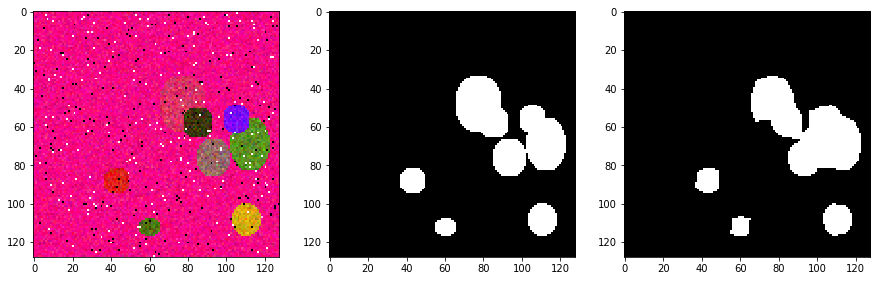

In [17]:
# ================================== YOUR CODE HERE ==================================
# ====================================================================================

### Скриншот tensorboard с графиками функции потерь и точности

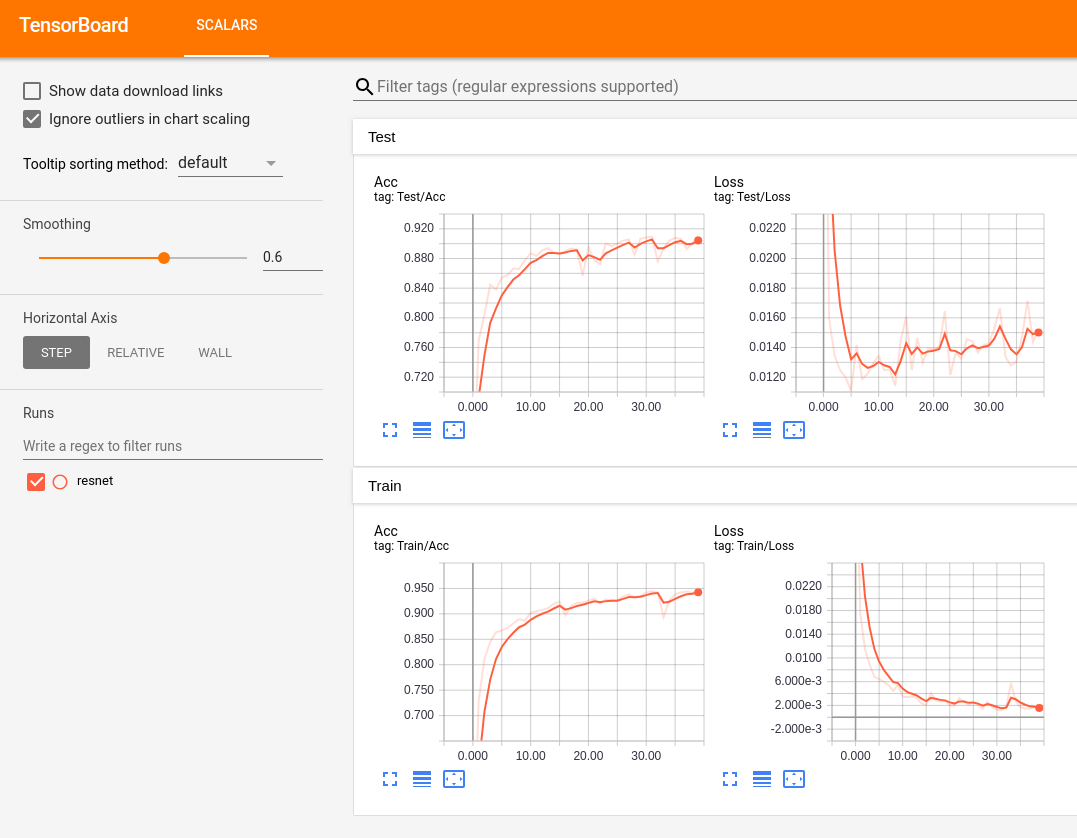

In [25]:
# ================================== YOUR CODE HERE ==================================
# ====================================================================================